In this notebook, we will code our first Reinforcement Learning agent from scratch to play FrozenLake ❄️ and Car Parking using Q-Learning

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/envs.gif" alt="Environments"/>

Objectives of this notebook 🏆
At the end of the notebook, you will:

- Be able to use Gymnasium, the environment library.
- Be able to code a Q-Learning agent from scratch.

## Setup

We’ll install multiple ones:

- `gymnasium`: Contains the FrozenLake-v1 ⛄ and Taxi-v3 🚕 environments.
- `pygame`: Used for the FrozenLake-v1 and Taxi-v3 UI.
- `numpy`: Used for handling our Q-table.

- `imageio`: To generate a replay video.

In [78]:
import gymnasium as gym
import numpy as np
import random
import imageio
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
for _ in tqdm(range(10)):
    pass

100%|██████████| 10/10 [00:00<00:00, 36954.22it/s]


# Q-Learning

*Q-Learning* **is the RL algorithm that**:

- Trains *Q-Function*, an **action-value function** that encoded, in internal memory, by a *Q-table* **that contains all the state-action pair values.**

- Given a state and action, our Q-Function **will search the Q-table for the corresponding value.**
    
<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-function-2.jpg" alt="Q function"  width="50%"/>

This is the Q-Learning pseudocode:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-learning-2.jpg" alt="Q-Learning" width="50%"/>

# Part 1: Frozen Lake ⛄ (non slippery version)

## Create and understand [FrozenLake environment ⛄](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)
---

💡 A good habit when you start to use an environment is to check its documentation

👉 https://gymnasium.farama.org/environments/toy_text/frozen_lake/

---

We're going to train our Q-Learning agent **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:

- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:

- `is_slippery=False`: The agent always moves **in the intended direction** due to the non-slippery nature of the frozen lake (deterministic).
- `is_slippery=True`: The agent **may not always move in the intended direction** due to the slippery nature of the frozen lake (stochastic).

## Create Env

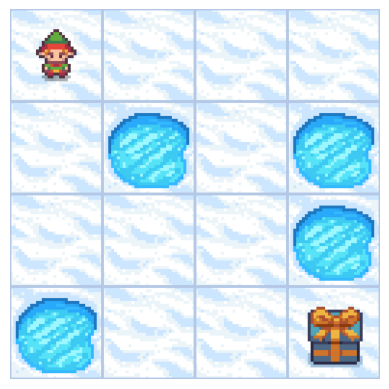

In [202]:
env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=False, render_mode = 'rgb_array')
# Reset the environment
env.reset()

# Render the environment
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.show()

### Let's see what the Environment packs for us

In [174]:
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 6


The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:
- 0: GO LEFT
- 1: GO DOWN
- 2: GO RIGHT
- 3: GO UP

Reward function 💰:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

## Create and Initialize the Q-Table 

Eg:
<img src="../images/Q_learning/Q-learning-1.jpg" alt="Q-Learning" width="30%"/>

In [175]:
state_space = env.observation_space.n #16
print("There are",state_space,"possible states")
action_space = env.action_space.n #4 #up, down, left, right
print("There are", action_space, "possible actions")


def initialize_q_table(state_space, action_space):
    q_table = np.zeros((state_space, action_space))
    return q_table

Qtable_frozenlake = initialize_q_table(state_space, action_space)

There are 16 possible states
There are 4 possible actions


## Define the policies

Remember we have two policies since Q-Learning is an **off-policy** algorithm. This means we're using a **different policy for acting and updating the value function**.

- Greedy-policy (updating policy)
- Epsilon-greedy policy (acting policy)

### Define the greedy policy 🤖

The greedy policy will also be the final policy we'll have when the Q-learning agent completes training. The greedy policy is used to select an action using the Q-table.

<img src="../images/Q_learning/off-on-policy.jpg" alt="Q-Learning" width="40%"/>


In [176]:
def greedy_policy(Qtable, state):
    # Exploitation: take the action with the highest state, action value
    action = np.argmax(Qtable[state])
    return action

### Define the epsilon-greedy policy 🤖

Epsilon-greedy is the training policy that handles the exploration/exploitation trade-off.

The idea with epsilon-greedy:

- With *probability 1 - ɛ* : **we do exploitation** (i.e. our agent selects the action with the highest state-action pair value).

- With *probability ɛ*: we do **exploration** (trying a random action).

In [177]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    random_epsilon = random.uniform(0, 1)
    # Suppose eps = 0.2, then 1-eps is 0.8 (exploitation 80%) and eps = 0.2 (explore 20% of the time)
    # Now, if we get random_epsilon = 0.63, then we exploit as this is in interval of 0.8
    if random_epsilon > epsilon: # Exploitation
        action = greedy_policy(Qtable, state) # Take the action with the highest value given a state
    else: # Exploration
        action = env.action_space.sample() # Take a random action
    return action

## Define the hyperparameters ⚙️

The exploration related hyperparamters are some of the most important ones.

- We need to make sure that our agent **explores enough of the state space** to learn a good value approximation. To do that, we need to have progressive decay of the epsilon.
- If you decrease epsilon too fast (too high decay_rate), **you take the risk that your agent will be stuck**, since your agent didn't explore enough of the state space and hence can't solve the problem.

In [219]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

## Create the training loop method

<img src="../images/Q_learning/Q-learning-2.jpg" alt="Q-Learning" width="40%"/>

<img src="../images/Q_learning/eps_vs_training.jpg" alt="Q-Learning" width="20%" style="background-color:white;"/>

An $f(x) = e^x$ curve

In [179]:
def train(n_training_episodes, learning_rate, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in tqdm(range(n_training_episodes)):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + np.exp(-decay_rate * episode) * (max_epsilon - min_epsilon)
        # Reset the environment at each start of the new episode
        state, info = env.reset()
        step = 0
        terminated = False # At fall or Goal
        truncated = False # Out of bound or out of time
        
        # Repeat until the episode is terminated
        for step in range(max_steps):
            # Choose an action using epsilon-greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            
            # Take the chosen action and observe the next state and reward
            new_state, reward, terminated, truncated, info = env.step(action)
            
            # Action taken through greedy-policy
            # Update Q-value: Q(s, a) := Q(s, a) + lr * [R_{t+1} + gamma * max Q(s_{t+1}, a) - Q(s,a)]
            Qtable[state,action] = Qtable[state, action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state, action])
            
            if terminated or truncated:
                break
            
            # Transition to the next state
            state = new_state
    
    return Qtable

In [180]:
print("Q table before training\n", Qtable_frozenlake)

Q table before training
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## Train the agent

In [181]:
Qtable_frozenlake = train(n_training_episodes, learning_rate, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  3%|▎         | 288/10000 [00:00<00:06, 1535.74it/s]

100%|██████████| 10000/10000 [00:02<00:00, 3529.62it/s]


In [269]:
print("Q table After training\n", Qtable_frozenlake)

Q table After training
 [[0.73509189 0.77378094 0.77378094 0.73509189]
 [0.73509189 0.         0.81450625 0.77378094]
 [0.77378094 0.857375   0.77378094 0.81450625]
 [0.81450625 0.         0.77378094 0.77378094]
 [0.77378094 0.81450625 0.         0.73509189]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.         0.81450625]
 [0.         0.         0.         0.        ]
 [0.81450625 0.         0.857375   0.77378094]
 [0.81450625 0.9025     0.9025     0.        ]
 [0.857375   0.95       0.         0.857375  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.95       0.857375  ]
 [0.9025     0.95       1.         0.9025    ]
 [0.         0.         0.         0.        ]]


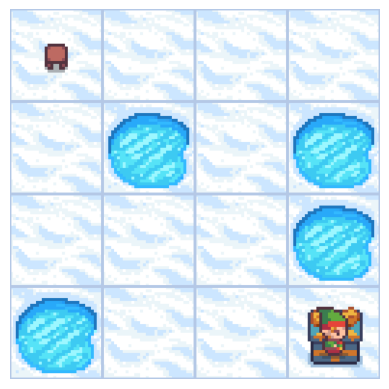

In [270]:
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.show()

### Tracing Optimal Path from Q-table

In [266]:
action_dict = {0: 'Left', 1: 'Down', 2: 'Right', 3: 'Up'}
state, info = env.reset()
terminated = False
truncated = False

while not terminated and not truncated:
    action = greedy_policy(Qtable_frozenlake, state)
    print(f"State: {state}, Action: {action_dict[action]}")
    state, reward, terminated, truncated, info = env.step(action)

State: 0, Action: Down
State: 4, Action: Down
State: 8, Action: Right
State: 9, Action: Down
State: 13, Action: Right
State: 14, Action: Right


## The evaluation method 📝

- We defined the evaluation method that we're going to use to test our Q-Learning agent.

In [273]:
def evaluate_agent(env, max_steps, n_eval_episodes, Qtable, seed):
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        
        step = 0
        terminated = False
        truncated = False
        total_rewards_per_ep = 0
        
        for step in range(max_steps):
            # Take the action with the highest Q-value
            action = greedy_policy(Qtable_frozenlake, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_per_ep += reward

            if terminated or truncated:
                break
            state = new_state
            
        episode_rewards.append(total_rewards_per_ep)
            
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward            

In [274]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

100%|██████████| 100/100 [00:00<00:00, 6646.76it/s]

Mean_reward=1.00 +/- 0.00


## Publish our trained model to the Hub and Record a video🔥

In [275]:
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save
from pathlib import Path
import datetime
import json
import pickle

In [292]:
def record_video(env, Qtable, out_dir, fps = 1):
    images = []
    state, info = env.reset() 
    terminated = False
    truncated = False
    img = env.render()
    images.append(img)
    while not terminated and not truncated:
        # Take the action with the highest Q-value
        action = greedy_policy(Qtable, state)
        new_state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        images.append(img)
        state = new_state
    
    imageio.mimsave(out_dir, [np.array(img) for img in images], fps=fps)

In [299]:
record_video(env, Qtable_frozenlake, "frozenlake.gif", fps=1)

In [294]:
def push_to_hub(
    repo_id, model, env, video_fps=1, local_repo_path="hub"
):
    """
    Evaluate, Generate a video and Upload a model to Hugging Face Hub.
    This method does the complete pipeline:
    - It evaluates the model
    - It generates the model card
    - It generates a replay video of the agent
    - It pushes everything to the Hub

    :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
    :param env
    :param video_fps: how many frame per seconds to record our video replay
    (with taxi-v3 and frozenlake-v1 we use 1)
    :param local_repo_path: where the local repository is
    """
    _, repo_name = repo_id.split("/")

    eval_env = env
    api = HfApi()

    # Step 1: Create the repo
    repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
    )

    # Step 2: Download files
    repo_local_path = Path(snapshot_download(repo_id=repo_id))

    # Step 3: Save the model
    if env.spec.kwargs.get("map_name"):
        model["map_name"] = env.spec.kwargs.get("map_name")
        if env.spec.kwargs.get("is_slippery", "") == False:
            model["slippery"] = False

    # Pickle the model
    with open((repo_local_path) / "q-learning.pkl", "wb") as f:
        pickle.dump(model, f)

    # Step 4: Evaluate the model and build JSON with evaluation metrics
    mean_reward, std_reward = evaluate_agent(
        eval_env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"]
    )

    evaluate_data = {
        "env_id": model["env_id"],
        "mean_reward": mean_reward,
        "n_eval_episodes": model["n_eval_episodes"],
        "eval_datetime": datetime.datetime.now().isoformat()
    }

    # Write a JSON file called "results.json" that will contain the
    # evaluation results
    with open(repo_local_path / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = model["env_id"]
    if env.spec.kwargs.get("map_name"):
        env_name += "-" + env.spec.kwargs.get("map_name")

    if env.spec.kwargs.get("is_slippery", "") == False:
        env_name += "-" + "no_slippery"

    metadata = {}
    metadata["tags"] = [env_name, "q-learning", "reinforcement-learning", "custom-implementation"]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
    )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **Q-Learning** Agent playing1 **{env_id}**
  This is a trained model of a **Q-Learning** agent playing **{env_id}** .

  ## Usage

  ```python

  model = load_from_hub(repo_id="{repo_id}", filename="q-learning.pkl")

  # Don't forget to check if you need to add additional attributes (is_slippery=False etc)
  env = gym.make(model["env_id"])
  ```
  """

    evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

    readme_path = repo_local_path / "README.md"
    readme = ""
    print(readme_path.exists())
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path = repo_local_path / "replay.mp4"
    record_video(env, model["qtable"], video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
        repo_id=repo_id,
        folder_path=repo_local_path,
        path_in_repo=".",
    )

    print("Your model is pushed to the Hub. You can view your model here: ", repo_url)

In [295]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": learning_rate,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Qtable_frozenlake
}

In [296]:
from dotenv import load_dotenv
load_dotenv()
ACCESS_TOKEN = os.getenv("HF_TOKEN")
USER_NAME = os.getenv("USER_NAME")

In [297]:
!huggingface-cli login --token $ACCESS_TOKEN

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `RL_token` has been saved to /home/naveen/.cache/huggingface/stored_tokens
Your token has been saved to /home/naveen/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [298]:
username = USER_NAME
repo_name = "q-FrozenLake-v1-4x4-noSlippery"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

100%|██████████| 100/100 [00:00<00:00, 6800.10it/s]


True
Your model is pushed to the Hub. You can view your model here:  https://huggingface.co/Naveen20o1/q-FrozenLake-v1-4x4-noSlippery
